# Test if A binary classifier can be trained using small set of intracellular differentially expressed genes as features
```
Andrew E. Davison
aedavids@ucsc.edu
6/5/23
```

Before we can test if our small set of intracellular differentially expresed genes can be used to make predictions on extracellular sample we must first demonstrate the model is able to make predictions on intracellular sample

**overview:**  
Tran a binary classifier using the 309 Pancrease and PAAD samples in our GTEX_TCGA data set

**output**  
logistic regression model is saved using joblib
- models/testIntraCellularBiomarkers/logisticRegresion.data
- models/testIntraCellularBiomarkers/StandardScaler.data

confusion matrix plot
- img/testIntraCellularBiomarkers/testIntraCellularBiomarkers.png

**ref:**
- extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/testIntraCellular-TE-BiomarkersOnExtracellularSamples.ipynb

In [1]:
# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

import joblib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib as pl

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

import time    

# add our local python packages to path
import sys
sys.path.append('../python/src')
from confusion_matrix.cf_matrix import make_confusion_matrix
import intraExtraRNA.deseqUtilities as du
import intraExtraRNA.transposableElementUtilities as teu
import intraExtraRNA.utilities as ut

LOCAL_CACHE_DIR="/scratch/aedavids/tmp"
NOTEBOOK_NAME = "testIntraCellularBiomarkers"
imgOutPl = pl.Path("img").joinpath(NOTEBOOK_NAME)
imgOutPl.mkdir(parents=True, exist_ok=True)

modelOutPL = pl.Path("models").joinpath(NOTEBOOK_NAME)
modelOutPL.mkdir(parents=True, exist_ok=True)

In [2]:
# common file paths
rootDir = "/private/groups/kimlab/GTEx_TCGA"
groupByDataDir = rootDir + "/groupbyGeneTrainingSets"
geneSignatureProfilesDir = rootDir + "/geneSignatureProfiles"

In [3]:
%%time 
# path to gene count file
trainGroupByGeneCountFilePath = groupByDataDir + "/GTEx_TCGA_TrainGroupby.csv"    
groupByGeneCountFilePath = ut.load(trainGroupByGeneCountFilePath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
groupedByGeneDF = pd.read_csv(groupByGeneCountFilePath, sep=",", index_col="geneId")

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/groupbyGeneTrainingSets/GTEx_TCGA_TrainGroupby.csv

CPU times: user 6min 40s, sys: 22.6 s, total: 7min 2s
Wall time: 6min 58s


In [4]:
groupedByGeneDF.head()#.loc[:, ["geneId"]]

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-3226-SM-5N9CT,GTEX-111CU-0326-SM-5GZXO,GTEX-111CU-0426-SM-5GZY1,GTEX-111CU-0526-SM-5EGHK,GTEX-111CU-0626-SM-5EGHL,GTEX-111CU-0826-SM-5EGIJ,...,UVM-WC-A881-TP,UVM-WC-A882-TP,UVM-WC-A883-TP,UVM-WC-A884-TP,UVM-WC-A888-TP,UVM-WC-AA9E-TP,UVM-YZ-A980-TP,UVM-YZ-A983-TP,UVM-YZ-A984-TP,UVM-YZ-A985-TP
geneId,,,,,,,,,,,,,,,,,,,,,
(A)n,9,1,3,13,1,2,2,1,0,0,...,7,7,3,2,20,0,7,3,4,1
(AAA)n,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(AAAAAAC)n,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(AAAAAAG)n,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(AAAAAAT)n,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
%%time
trainingColDataFilePath = groupByDataDir + "/GTEx_TCGA_TrainColData.csv"
colDataFilePath = ut.load(trainingColDataFilePath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
colDataDF = pd.read_csv(colDataFilePath, sep=",")

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/groupbyGeneTrainingSets/GTEx_TCGA_TrainColData.csv

CPU times: user 19.7 ms, sys: 7.71 ms, total: 27.5 ms
Wall time: 24.5 ms


In [6]:
%%time
oneVsAllDataDir = rootDir + "/1vsAll"    
estimatedScalingFactorsFilePath = oneVsAllDataDir + "/estimatedSizeFactors.csv"
scalingFactorsPath = ut.load(estimatedScalingFactorsFilePath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
scalingFactorDF = pd.read_csv(scalingFactorsPath, sep=",")

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/1vsAll/estimatedSizeFactors.csv

CPU times: user 8.87 ms, sys: 63 µs, total: 8.93 ms
Wall time: 6.23 ms


In [7]:
normalizedDF = du.normalize(groupedByGeneDF, scalingFactorDF)
print(normalizedDF.shape)

(15801, 74777)


In [8]:
pancDF = ut.selectSamples(colDataDF, normalizedDF, ['PAAD', 'Pancreas'])
print(pancDF.shape)
pancDF.head()

(304, 74777)


geneId,(A)n,(AAA)n,(AAAAAAC)n,(AAAAAAG)n,(AAAAAAT)n,(AAAAAC)n,(AAAAACA)n,(AAAAACC)n,(AAAAACT)n,(AAAAAG)n,...,tRNA-Ser-TCY,tRNA-Thr-ACA,tRNA-Thr-ACG,tRNA-Thr-ACY,tRNA-Trp-TGG,tRNA-Tyr-TAC,tRNA-Tyr-TAT,tRNA-Val-GTA,tRNA-Val-GTG,tRNA-Val-GTY
GTEX-111CU-0526-SM-5EGHK,0.394930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTEX-111YS-1226-SM-5EGGJ,0.393574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTEX-1128S-0826-SM-5GZZI,1.578834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTEX-11DXX-0926-SM-5H112,0.500841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTEX-11GSP-0426-SM-5A5KX,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##  Select the best PAAD biomarkers

In [9]:
# load our 1vsAll DESeq2 results
category = 'PAAD_vs_all.results'
resultsFile = '/private/groups/kimlab/GTEx_TCGA/1vsAll/' + category
resultsFile = ut.load(resultsFile, localCacheDir=LOCAL_CACHE_DIR, verbose=True)

resultsDF = du.loadDESEqResults(resultsFile, skiprows=7)
print(f'shape: {resultsDF.shape}')
resultsDF.head()

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/1vsAll/PAAD_vs_all.results

shape: (65406, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
name,,,,,,
CELA2B,1332.659848,13.266912,0.484407,27.387922,3.819727e-165,1.412612e-160
ENPP3,321.790901,-5.689927,0.222926,-25.523852,1.071664e-143,1.981613e-139
VILL,687.481732,3.114475,0.127290,24.467473,3.279913e-132,4.043259e-128
POU3F3,675.194100,-8.707841,0.364690,-23.877352,5.266121e-126,4.868792e-122
LRP2,1211.112568,-7.771070,0.330318,-23.525996,2.211008e-122,1.635350e-118


In [10]:
# print(f'TEResultsDF.shape : {TEResultsDF.shape}')
# bestDESeq2DF = du.selectBest(TEResultsDF, topN=20) 

bestDESeq2DF = du.selectBest(resultsDF, topN=20) 
print(f'shape: {bestDESeq2DF.shape}')

print('\ndo not be confused by descriptive stats for lfc. we filter using abs')
print('min abs > lfcThreshold')

colOrderList = ['baseMean', 'padj',  'absLog2FoldChange', 'log2FoldChange' ]
bestDESeq2DF.loc[:, colOrderList].describe()

print()
bestDESeq2DF

significantDF.shape : (12915, 6)
shape: (20, 7)

do not be confused by descriptive stats for lfc. we filter using abs
min abs > lfcThreshold



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,absLog2FoldChange
name,,,,,,,
KRT5,48084.270387,-5.580854,0.355234,-15.710357,1.284545e-55,4.612139e-53,5.580854
KRT6A,36638.110998,-3.769981,0.394781,-9.549559,1.302500e-21,4.229065e-20,3.769981
REG1A,26610.922181,4.781937,0.496257,9.636004,5.633872e-22,1.888956e-20,4.781937
CRYAB,21594.014674,-3.927250,0.214205,-18.334102,4.422599e-75,5.111142e-72,3.927250
LYZ,17275.659268,2.271530,0.279510,8.126834,4.406469e-16,7.288015e-15,2.271530
ATP1A2,11623.740525,-3.823885,0.267546,-14.292452,2.438685e-46,5.465907e-44,3.823885
C7,9941.646224,2.580039,0.232117,11.115266,1.057354e-28,7.135593e-27,2.580039
FAM107A,9492.796004,-2.796470,0.229265,-12.197542,3.203469e-34,3.346630e-32,2.796470
PKP1,9426.533713,-3.861180,0.317742,-12.151933,5.602479e-34,5.771333e-32,3.861180


In [11]:
#select row that match our best genes
bestGenesList = bestDESeq2DF.index.to_list()
print(' '.join(bestGenesList[0:5]))
print(' '.join(bestGenesList[5:10]))
print(' '.join(bestGenesList[10:15]))
print(' '.join(bestGenesList[15:]))

KRT5 KRT6A REG1A CRYAB LYZ
ATP1A2 C7 FAM107A PKP1 FABP5
KIF5A KRT15 NTRK2 FCGBP GPM6B
MUC5B NDRG4 SLC34A2 OLFM4 SLC1A3


## Run logistic regression

In [12]:
# select best genes
bestCounTmpDF = pancDF.loc[:, bestGenesList]
print(bestCounTmpDF.shape)

(304, 20)


In [13]:
selectSamples = colDataDF.loc[:, "sample_id"].isin(pancDF.index)
conditionList = colDataDF.loc[selectSamples, 'category'].tolist()

labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(conditionList)

# quick visual check
tmpDF = pd.DataFrame( {
    'cat':conditionList,
    'oneHot': y } )

display(tmpDF.groupby(by="cat").count())
display(tmpDF.head())
print()
tmpDF.tail()

,oneHot
cat,
PAAD,107
Pancreas,197


,cat,oneHot
0,Pancreas,1
1,Pancreas,1
2,Pancreas,1
3,Pancreas,1
4,Pancreas,1


,cat,oneHot
299,PAAD,0
300,PAAD,0
301,PAAD,0
302,PAAD,0
303,PAAD,0


In [14]:
XNP = bestCounTmpDF.values #.transpose()
print(XNP.shape)

(304, 20)


In [15]:
%%time
# # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lrModel = LogisticRegression()
# #             , penalty='l2' # regularization some penalities do not work with some solvers
# # tol=0.0001
# # lrModel.fit(XNP, y, C=1.0 
# #             ,random_state=42           
# #             ,solver='lbfgs' |
# #             , max_iterint=100
# #           )

# save the scaler
scaler = StandardScaler().fit(XNP)
ScalerFilePath = modelOutPL.joinpath("standardScaler.data")
print(ScalerFilePath)
joblib.dump(scaler, ScalerFilePath)

XScaled = scaler.transform(XNP)

lrModel = lrModel.fit(XScaled, y)

models/testIntraCellularBiomarkers/standardScaler.data
CPU times: user 8.72 ms, sys: 3.38 ms, total: 12.1 ms
Wall time: 11.6 ms


In [16]:
# save the model
# add an attribute containing the list of feature names
lrModel.features = bestGenesList
modelFilePath = modelOutPL.joinpath("logisticRegresion.data")
joblib.dump(lrModel, modelFilePath)

['models/testIntraCellularBiomarkers/logisticRegresion.data']

In [17]:
yHat = lrModel.predict(XScaled)
print('{} Accuracy : {:.2f}'.format(lrModel, lrModel.score(XScaled, y)))

LogisticRegression() Accuracy : 0.98


In [18]:
confusion_matrix = confusion_matrix(y, yHat)
print(confusion_matrix)

[[102   5]
 [  0 197]]


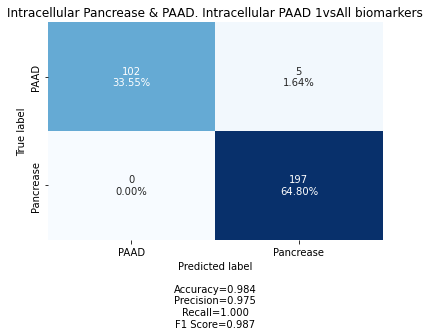

In [19]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
#categories = ['Zero', 'One']
categories = ['PAAD', 'Pancrease']
title = "Intracellular Pancrease & PAAD. Intracellular PAAD 1vsAll biomarkers"
fig,panel = make_confusion_matrix(confusion_matrix, 
                      # group_names=labels,
                      categories=categories, 
                      cbar=False,
                      count=True,
                      cmap='Blues',
                      title=title
                     )

In [20]:
imgFilePL = imgOutPl.joinpath( NOTEBOOK_NAME + ".png")
print(imgFilePL)
fig.savefig(imgFilePL, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)

img/testIntraCellularBiomarkers/testIntraCellularBiomarkers.png
